In [12]:
import pandas as pd

# Load your traffic dataset (replace 'Traffic_Volumes_-_Provincial_Highway_System.csv' with your actual file path)
traffic_data = pd.read_csv('Traffic_Volumes_-_Provincial_Highway_System.csv')

# Remove the specified columns from the DataFrame
columns_to_remove = ['HIGHWAY', 'SECTION ID', 'SECTION', 'SECTION LENGTH', 'SECTION DESCRIPTION', 'DESCRIPTION', 'TYPE', 'PRIORITY_POINTS']
traffic_data = traffic_data.drop(columns=columns_to_remove)

# Filter the dataset to include only rows with 'county' value 'HFX' and year >= 2019
traffic_data = traffic_data[(traffic_data['COUNTY'] == 'HFX') & (traffic_data['Date'].str[-4:] >= '2019')]

# Convert the 'Date' column to datetime format
traffic_data['Date'] = pd.to_datetime(traffic_data['Date'], errors='coerce')

# Sort the dataset by the 'Date' column in ascending order
traffic_data = traffic_data.sort_values(by='Date')

# Remove the specified columns from the DataFrame
columns_to_remove = ['COUNTY']
traffic_data = traffic_data.drop(columns=columns_to_remove)

# Clean and convert numeric columns by removing commas and converting to float
numeric_columns = ['ADT', 'AADT', 'PTRUCKS', '85PCT']
for col in numeric_columns:
    if traffic_data[col].dtype == object:
        traffic_data[col] = traffic_data[col].str.replace(',', '').astype(float)
        
# Replace empty rows in the 'DIRECTION' column with 'T'
traffic_data['DIRECTION'].fillna('T', inplace=True)

# Forward fill the 'GROUP' column to fill missing values
traffic_data['GROUP'].fillna(method='ffill', inplace=True)
        
        
# Group the data by 'Date' and choose an aggregation function (e.g., 'mean')
traffic_data = traffic_data.groupby('Date').agg({
    'ADT': 'mean',
    'AADT': 'mean',
    'PTRUCKS': 'mean',
    '85PCT': 'mean',
    'DIRECTION': 'first',  # Choose 'first' for the 'DIRECTION' column
    'GROUP': 'first'       # Choose 'first' for the 'GROUP' column
}).reset_index()

# Handle missing values by filling with the mean of each colum
traffic_data['ADT'].fillna(traffic_data['ADT'].mean(), inplace=True)
traffic_data['AADT'].fillna(traffic_data['AADT'].mean(), inplace=True)
traffic_data['PTRUCKS'].fillna(traffic_data['PTRUCKS'].mean(), inplace=True)
traffic_data['85PCT'].fillna(traffic_data['85PCT'].mean(), inplace=True)


# Save the sorted and filtered dataset to a new CSV file
traffic_data.to_csv('traffic_data.csv', index=False)

print(traffic_data)

          Date           ADT      AADT   PTRUCKS       85PCT DIRECTION GROUP
0   2019-01-01  10073.304419  17902.50  9.000000  114.666667         T     C
1   2019-04-29  26354.000000  25500.00  8.345707  102.702778         S     A
2   2019-05-02   5705.000000   5568.75  4.500000  102.702778         W     B
3   2019-05-09   1103.625000   1138.75  6.500000  102.702778         T     B
4   2019-05-16   3495.142857   3380.00  7.500000  102.702778         W     A
..         ...           ...       ...       ...         ...       ...   ...
133 2022-10-25  19488.000000  19500.00  8.345707  102.702778         T     A
134 2022-11-02   5794.000000   6020.00  8.345707  102.702778         T     A
135 2022-11-06  27875.500000  28185.00  8.345707  102.702778         N    AA
136 2022-11-17  23241.000000  23060.00  8.345707  102.702778         N    AA
137 2022-11-23   6287.500000   7210.00  8.345707  102.702778         E     C

[138 rows x 7 columns]


In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load your PM2.5 dataset
pm25_data = pd.read_csv('Nova_Scotia_Provincial_Ambient_Fine_Particulate_Matter__PM2.5__Hourly_Data_Halifax_BAM_T640.csv')

# Convert the 'Date & time' column to datetime format
pm25_data['Date & time'] = pd.to_datetime(pm25_data['Date & time'], format='%Y/%m/%d %I:%M:%S %p')

# Extract the date from the datetime column
pm25_data['Date'] = pm25_data['Date & time'].dt.date

# Filter the data starting from 2019
pm25_data = pm25_data[pm25_data['Date & time'].dt.year >= 2019]

# Compute daily average PM2.5 levels
daily_pm25 = pm25_data.groupby('Date')['Average'].mean().reset_index()
daily_pm25.columns = ['Date', 'daily_average_pm25']

# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Normalize the 'daily_average_pm25' column
daily_pm25['normalized_pm25'] = scaler.fit_transform(daily_pm25[['daily_average_pm25']])

# Discretize PM2.5 levels based on the threshold
daily_pm25['pm25_category'] = daily_pm25['normalized_pm25'].apply(lambda x: 'High' if x >= 0.5 else 'Low')

# Map 'Low' to 0 and 'High' to 1 in the 'pm25_category' column
daily_pm25['pm25_category'] = daily_pm25['pm25_category'].map({'Low': 0, 'High': 1})

# Save only the 'date' and 'pm25_category' columns to a new CSV file
daily_pm25[['Date', 'pm25_category']].to_csv('pm_values.csv', index=False)

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your traffic dataset
traffic_data = pd.read_csv('traffic_data.csv')

# Load the CSV file containing the target variable
target_data = pd.read_csv('pm_values.csv')

# Assuming there's a common column 'ID' between the datasets
merged_data = pd.merge(traffic_data, target_data, on='Date')

print(merged_data)

# Save the sorted and filtered dataset to a new CSV file
merged_data.to_csv('merged_data.csv', index=False)

          Date           ADT          AADT    PTRUCKS       85PCT DIRECTION  \
0   2019-01-01  10073.304419  17902.500000   9.000000  114.666667         T   
1   2019-04-29  26354.000000  25500.000000   8.345707  102.702778         S   
2   2019-05-02   5705.000000   5568.750000   4.500000  102.702778         W   
3   2019-05-09   1103.625000   1138.750000   6.500000  102.702778         T   
4   2019-05-16   3495.142857   3380.000000   7.500000  102.702778         W   
..         ...           ...           ...        ...         ...       ...   
92  2021-11-01  33425.600000  34720.000000  13.500000  102.702778         N   
93  2021-11-04   1104.777778   1173.333333   6.750000  102.702778         T   
94  2021-11-17  10944.333333  10852.111111   8.345707  102.702778         E   
95  2021-11-22  11742.000000  11600.000000   8.345707  102.702778         E   
96  2021-11-25  14323.400000  14416.000000   8.345707  102.702778         W   

   GROUP  pm25_category  
0      C              0  

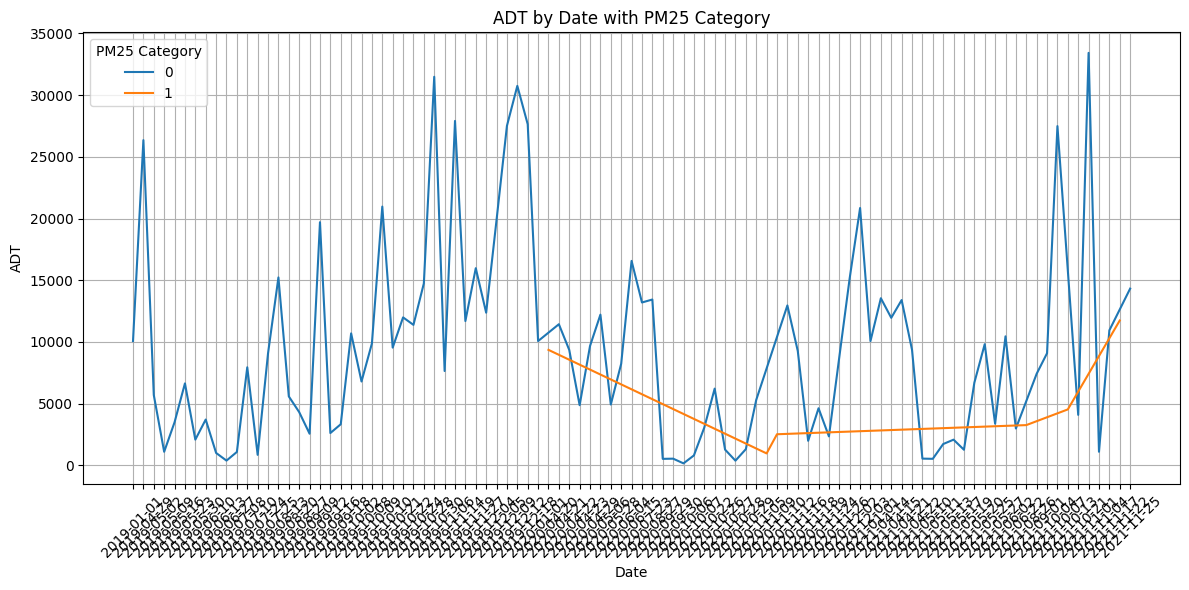

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a line plot for ADT by date with different colors for each 'pm25_category'
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='ADT', hue='pm25_category', data=data)
plt.xlabel('Date')
plt.ylabel('ADT')
plt.title('ADT by Date with PM25 Category')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='PM25 Category')
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

# Load your dataset
data = pd.read_csv('merged_data.csv')

# Calculate the entropy of the target variable (pm25_category)
target_entropy = entropy(data['pm25_category'].value_counts(), base=2)

# Initialize a dictionary to store Information Gain for each attribute
information_gain = {}

# Calculate Information Gain for each attribute
for attribute in ['ADT', 'AADT', 'PTRUCKS', '85PCT']:
    attribute_entropy = 0
    for value in data[attribute].unique():
        subset = data[data[attribute] == value]
        weight = len(subset) / len(data)
        attribute_entropy += weight * entropy(subset['pm25_category'].value_counts(), base=2)
    information_gain[attribute] = target_entropy - attribute_entropy

# Select the attribute with the highest Information Gain
best_attribute = max(information_gain, key=information_gain.get)
print(f"The best attribute to split on based on Information Gain is: {best_attribute}")


The best attribute to split on is: ADT


In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

# Load your dataset (replace 'your_dataset.csv' with your actual file path)
data = pd.read_csv('merged_data.csv')

# Define the target variable
target_variable = 'pm25_category'

# Exclude 'Date' column from the feature set
X = data.drop(['Date', target_variable], axis=1)
y = data[target_variable]

# Initialize the DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)

# Create an empty dictionary to store Gini importances
gini_importance = {}

# Loop through each feature and fit the classifier
for feature in X.columns:
    X_feature = X[[feature]]
    clf.fit(X_feature, y)
    gini_importance[feature] = clf.tree_.impurity[0]

# Sort features by Gini impurity in descending order
sorted_features = sorted(gini_importance.items(), key=lambda x: x[1], reverse=True)

# Get the best feature for splitting
best_feature, best_gini = sorted_features[0]

print("Best feature for splitting:", best_feature)


ValueError: could not convert string to float: 'T'

In [17]:
import pandas as pd
import numpy as np

# Load your dataset
data = pd.read_csv('merged_data.csv')

# Define the target variable
target_variable = 'pm25_category'

# Calculate the initial entropy of the target variable
def entropy(data, target_variable):
    unique_classes = data[target_variable].unique()
    entropy_value = 0
    total_samples = len(data)
    
    for c in unique_classes:
        p = len(data[data[target_variable] == c]) / total_samples
        entropy_value -= p * np.log2(p)
    
    return entropy_value

initial_entropy = entropy(data, target_variable)

# Calculate entropy for each feature and Information Gain
features_to_exclude = ['Date', target_variable]
feature_entropy = {}

for feature in data.columns:
    if feature not in features_to_exclude:
        weighted_entropy = 0
        unique_values = data[feature].unique()
        
        for value in unique_values:
            subset = data[data[feature] == value]
            weighted_entropy += len(subset) / len(data) * entropy(subset, target_variable)
        
        feature_entropy[feature] = weighted_entropy

# Calculate Information Gain for each feature
information_gain = {feature: initial_entropy - entropy for feature, entropy in feature_entropy.items()}

# Sort features by Information Gain in descending order
sorted_features = sorted(information_gain.items(), key=lambda x: x[1], reverse=True)

# Get the Information Gain for each feature
for feature, ig in sorted_features:
    print(f"Feature: {feature}, Information Gain: {ig}")


Feature: ADT, Information Gain: 0.3347676126777638
Feature: AADT, Information Gain: 0.31414905597673287
Feature: PTRUCKS, Information Gain: 0.07141303729750548
Feature: GROUP, Information Gain: 0.06743924473031682
Feature: DIRECTION, Information Gain: 0.031235214756595464
Feature: 85PCT, Information Gain: 0.004879405991806918


In [5]:
# Cell 1: Load and Preprocess Data (Common to both classifiers)
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset (replace 'your_dataset.csv' with your actual dataset file path)
data = pd.read_csv('merged_data.csv')

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Extract year, month, and day from the 'Date' column
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Drop the original 'Date' column
data = data.drop(columns=['Date'])

# # Perform one-hot encoding for the 'DIRECTION' column
# data = pd.get_dummies(data, columns=['DIRECTION'], prefix=['Direction'])

# # Perform one-hot encoding for the 'GROUP' column
# data = pd.get_dummies(data, columns=['GROUP'], prefix=['Group'])

# Separate the features (X) and target (y) variable
X = data.drop(columns=['pm25_category'])  # Features
y = data['pm25_category']  # Target variable

# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create a DecisionTreeClassifier with 'entropy' as the criterion
clf_info_gain = DecisionTreeClassifier(criterion='entropy')

# Fit the classifier to the training data
clf_info_gain.fit(X_train, y_train)

# Make predictions on the test data
y_pred_info_gain = clf_info_gain.predict(X_test)

# Evaluate the model's accuracy
accuracy_info_gain = accuracy_score(y_test, y_pred_info_gain)
print("Information Gain Accuracy:", accuracy_info_gain)

Information Gain Accuracy: 0.9


In [7]:
# Cell 3: Decision Tree Classifier using Gini Index
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create a DecisionTreeClassifier with 'gini' as the criterion
clf_gini = DecisionTreeClassifier(criterion='gini')

# Fit the classifier to the training data
clf_gini.fit(X_train, y_train)

# Make predictions on the test data
y_pred_gini = clf_gini.predict(X_test)

# Evaluate the model's accuracy
accuracy_gini = accuracy_score(y_test, y_pred_gini)
print("Gini Index Accuracy:", accuracy_gini)

Gini Index Accuracy: 0.9


In [8]:
print("Information Gain Accuracy:", accuracy_info_gain)
print("Gini Index Accuracy:", accuracy_gini)

Information Gain Accuracy: 0.9
Gini Index Accuracy: 0.9


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Create a confusion matrix for the Information Gain classifier
confusion_matrix_info_gain = confusion_matrix(y_test, y_pred_info_gain)

# Create a confusion matrix for the Gini Index classifier
confusion_matrix_gini = confusion_matrix(y_test, y_pred_gini)

# Define a function to calculate specificity
def specificity_score(confusion_matrix):
    tn, fp, fn, tp = confusion_matrix.ravel()
    specificity = tn / (tn + fp)
    return specificity

# Calculate accuracy, precision, recall, specificity, and f-measure for both classifiers
accuracy_info_gain = accuracy_score(y_test, y_pred_info_gain)
precision_info_gain = precision_score(y_test, y_pred_info_gain, pos_label=0)
recall_info_gain = recall_score(y_test, y_pred_info_gain, pos_label=0)
specificity_info_gain = specificity_score(confusion_matrix_info_gain)
f1_score_info_gain = f1_score(y_test, y_pred_info_gain, pos_label=0)

accuracy_gini = accuracy_score(y_test, y_pred_gini)
precision_gini = precision_score(y_test, y_pred_gini, pos_label=0)
recall_gini = recall_score(y_test, y_pred_gini, pos_label=0)
specificity_gini = specificity_score(confusion_matrix_gini)
f1_score_gini = f1_score(y_test, y_pred_gini, pos_label=0)

# Display the results
print("Information Gain Classifier:")
print("Accuracy:", accuracy_info_gain)
print("Precision:", precision_info_gain)
print("Recall:", recall_info_gain)
print("Specificity:", specificity_info_gain)
print("F-measure:", f1_score_info_gain)

print("\nGini Index Classifier:")
print("Accuracy:", accuracy_gini)
print("Precision:", precision_gini)
print("Recall:", recall_gini)
print("Specificity:", specificity_gini)
print("F-measure:", f1_score_gini)


Information Gain Classifier:
Accuracy: 0.9
Precision: 0.9
Recall: 1.0
Specificity: 1.0
F-measure: 0.9473684210526316

Gini Index Classifier:
Accuracy: 0.9
Precision: 0.9
Recall: 1.0
Specificity: 1.0
F-measure: 0.9473684210526316


In [11]:
from sklearn.metrics import make_scorer

# Separate the features (X) and target (y) variable
X = data.drop(columns=['pm25_category'])  # Features
y = data['pm25_category']  # Target variable

# Define the parameter grid to search over
param_grid = {
    'max_depth': [1, 2, 4],  # You can specify different values here
    'min_samples_split': [2, 5, 10],  # You can specify different values here
    'min_samples_leaf': [1, 2, 4]  # You can specify different values here
}

# Create a DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)

# Create a custom scoring function (F1-score)
scorer = make_scorer(f1_score, pos_label=0)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scorer, cv=5)
grid_search.fit(X, y)

# Get the best hyperparameters
best_max_depth = grid_search.best_params_['max_depth']
best_min_samples_split = grid_search.best_params_['min_samples_split']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']

print("Best max_depth:", best_max_depth)
print("Best min_samples_split:", best_min_samples_split)
print("Best min_samples_leaf:", best_min_samples_leaf)

NameError: name 'GridSearchCV' is not defined

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the Random Forest model
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, pos_label=0)
recall_rf = recall_score(y_test, y_pred_rf, pos_label=0)
f1_score_rf = f1_score(y_test, y_pred_rf, pos_label=0)
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("\nRandom Forest:")
print("Accuracy:", accuracy_gini)
print("Precision:", precision_gini)
print("Recall:", recall_gini)
print("Specificity:", specificity_gini)
print("F-measure:", f1_score_gini)

